In [ ]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 2.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import requests
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, average_precision_score,recall_score,f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
#from keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras import backend as K
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

In [ ]:
def ListMaker(no_of_class , cons_mat):
  cons_mat = cons_mat.tolist()
  l1 = []
  for k in range(no_of_class):
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    for i in range(0,5):
      for j in range(0,5):
        if(i == k and j==k):
          TP = cons_mat[i][k]
        elif(i == j):
          TN = TN + cons_mat[i][j]
        elif(j == k):
          FP = FP + cons_mat[i][j]
        elif(i == k):
          FN = FN + cons_mat[i][j]
        else:
          TN = TN + cons_mat[i][j]
    temp = []
    temp.append(TN)
    temp.append(TP)
    temp.append(FP)
    temp.append(FN)
    l1.append(temp)
  return l1



def specificity(temp):
  TN = temp[0]
  TP = temp[1]
  FP = temp[2]
  FN = temp[3]  
  TPR = TN/(TN+FP)

  return TPR

def positive_predictive_value(temp):
  try:
    TN = temp[0]
    TP = temp[1]
    FP = temp[2]
    FN = temp[3]
    PPV = TP/(TP+FP)
    return PPV
  except ZeroDivisionError:
    import math
    return math.inf

def Diagnostic_Odds_Ratio(temp):
  try:
    TN = temp[0]
    TP = temp[1]
    FP = temp[2]
    FN = temp[3]
    return (TP/FN) / (FP/TN)  
  except ZeroDivisionError:
    import math
    return math.inf
def CohenKappa(temp):
  TN = temp[0]
  TP = temp[1]
  FP = temp[2]
  FN = temp[3]

  po = ( TP + TN ) /  (TP + FP + TN  + FN)
  pe = ( TN + FP ) * (TN + FN) + (FN + TP) * (FP + TP) 
  return (po-pe)/(1-pe)


def sensitivity(temp):
  TN = temp[0]
  TP = temp[1]
  FP = temp[2]
  FN = temp[3]
  return TP/ ( TP+FN )

def print_matrix(temp, name_of_classes):
  spec = 0
  ppv = 0
  dor = 0
  kappa = 0
  sen = 0
  count = 0
  for i in temp:
    
    print(name_of_classes[count]," Sensitivity = ",sensitivity(i))
    print(name_of_classes[count]," Specificity = ",specificity(i))
    print(name_of_classes[count]," Positive Predictive Value = ",positive_predictive_value(i))
    print(name_of_classes[count]," Diagonstic Odds Ratio = ",Diagnostic_Odds_Ratio(i))
    print(name_of_classes[count]," Cohen Kappa = ",CohenKappa(i))
    print("\n\n")
    spec = specificity(i) + spec
    ppv = ppv + positive_predictive_value(i)
    dor = dor + Diagnostic_Odds_Ratio(i)
    kappa = kappa + CohenKappa(i)
    sen = sen + sensitivity(i)
    print("\n\n")
    
    count+=1

  print("\n\n Average Values ")
  print("Sensitivity = ",sen/len(temp))
  print("Specificity = ",spec/len(temp))
  print("Positive Predictive Value = ",ppv/len(temp))
  print("Diagonstic Odds Ratio = ",dor/len(temp))
  print("Cohen Kappa = ",kappa/len(temp))


In [ ]:
import itertools

## code for creating confusion Matrix based from arXiv:1805.0079
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
#from arrhythmia classification kernel from kaggle
#evaluates the model
def evaluate_model(history,X_test_in,y_test_in,model):
    from sklearn.metrics import classification_report
    scores = model.evaluate(X_test_in,y_test_in)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    #plot epoch vs accuracy and epoch vs loss for training and validation sets    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test_in:
        y_true.append(np.argmax(element))
    print(y_true)
    prediction_proba=model.predict(X_test_in)
    prediction_proba_list = prediction_proba.tolist()
    print(prediction_proba_list)
    prediction = []
    for i in range(len(prediction_proba_list)):
      prediction.append( prediction_proba_list[i].index( max(prediction_proba_list[i]) ) )

    #prediction=np.argmax(prediction_proba,axis=1)
    print(prediction)

    cf_matrix = confusion_matrix(y_true, prediction)
    print(classification_report(y_true,prediction))
    print(cf_matrix)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cf_matrix, classes=['Normal','Supraventricular ectopic', 'entricular ectopic', 'Fusion', 'Unknown'],normalize=False,title='Confusion matrix')
    plt.show()
    
    
    return cf_matrix


In [ ]:
# Distribution graphs (histogram/bar graph) of column data

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(int(nGraphRow), int(nGraphPerRow), i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Setting  the data set directory
os.chdir("/content/drive/MyDrive")
print(os.listdir(r"dataset/"))

['mitbih_test.csv', 'mitbih_train.csv', 'ptbdb_abnormal.csv', 'ptbdb_normal.csv']


In [ ]:
#import the data sets
train_mit=pd.read_csv('dataset/mitbih_train.csv',header=None)
test_mit=pd.read_csv('dataset/mitbih_test.csv',header=None)


In [ ]:
train_mit.info()
test_mit.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


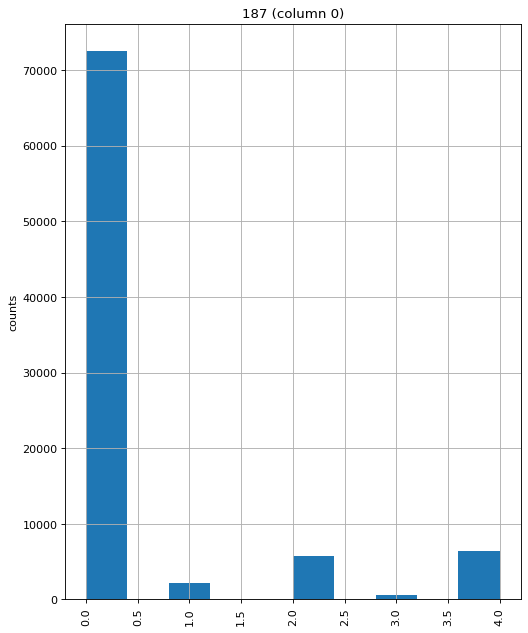

In [ ]:
plotPerColumnDistribution(train_mit, 5, 5)

In [ ]:
#plotScatterMatrix(train_mit, 10, 10)

In [ ]:
#Shows the classes stored in 187 index of mit dataset with count for each
#here there are 5 classes
train_mit[187]=train_mit[187].astype(int)
mit_train_classes=train_mit[187].value_counts()
print(mit_train_classes)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [ ]:
#Shows the classes stored in 187 index of mit dataset with count for each
#here there are 5 classes
test_mit[187]=test_mit[187].astype(int)
mit_test_classes=test_mit[187].value_counts()
print(mit_test_classes)

0    18118
4     1608
2     1448
1      556
3      162
Name: 187, dtype: int64


In [ ]:
comb_ds=pd.concat([train_mit, test_mit], axis=0)

In [ ]:
#the classes stored in 187 index of combined dataset
comb_ds[187]=comb_ds[187].astype(int)
train_comb_classes=comb_ds[187].value_counts()
print(train_comb_classes)

0    90589
4     8039
2     7236
1     2779
3      803
Name: 187, dtype: int64


In [ ]:
#Now to split the dataset into Train, Validate , test
#shuffle with  80% 10% 10% split
train, validate, test = np.split(comb_ds.sample(frac=1), [int(.8*len(comb_ds)), int(.9*len(comb_ds))])

In [ ]:
#prints a sample from the test database for each class
each_sample=train.groupby(187,group_keys=False).apply(lambda train : train.sample(1))
each_sample

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
68618,1.000000,0.915916,0.729730,0.483483,0.423423,0.378378,0.390390,0.465465,0.504505,0.462462,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
73532,1.000000,0.895874,0.400786,0.180747,0.131631,0.119843,0.110020,0.170923,0.273084,0.444008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
18685,0.774554,0.861607,0.917411,0.834821,0.790179,0.774554,0.803571,0.808036,0.651786,0.345982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
81064,0.983283,0.761398,0.379939,0.107903,0.057751,0.159574,0.188450,0.159574,0.162614,0.150456,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
85688,0.894737,0.526316,0.540351,0.536842,0.526316,0.498246,0.477193,0.424561,0.308772,0.171930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


Text(0.5, 0, 'Time')

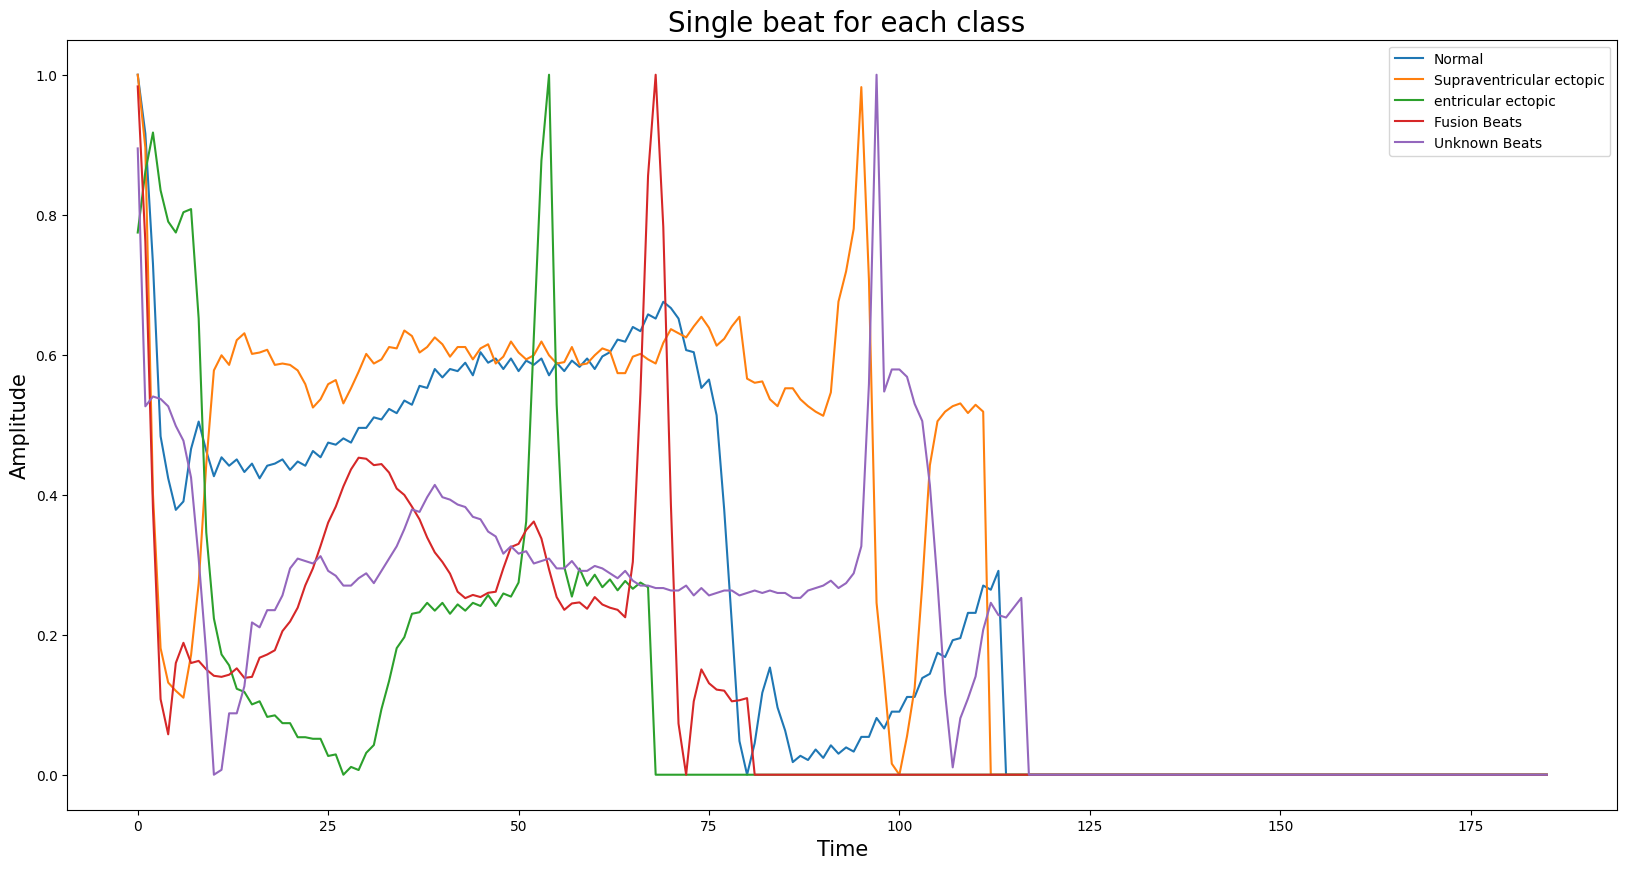

In [ ]:
 #plot normal Ecg 
plt.figure(figsize=(20,10))
plt.plot(each_sample.iloc[0,:186],label='Normal')
# plot Supraventricular Ectopic ECG 
plt.plot(each_sample.iloc[1,:186],label='Supraventricular ectopic')
# plot Ventricular Ectopic ECG
plt.plot(each_sample.iloc[2,:186],label='entricular ectopic')
# plot Fusion ECG
plt.plot(each_sample.iloc[3,:186],label='Fusion Beats')
# plot an unknown ECG
plt.plot(each_sample.iloc[4,:186],label='Unknown Beats')
plt.legend()
plt.title(" Single beat for each class", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time", fontsize=15)

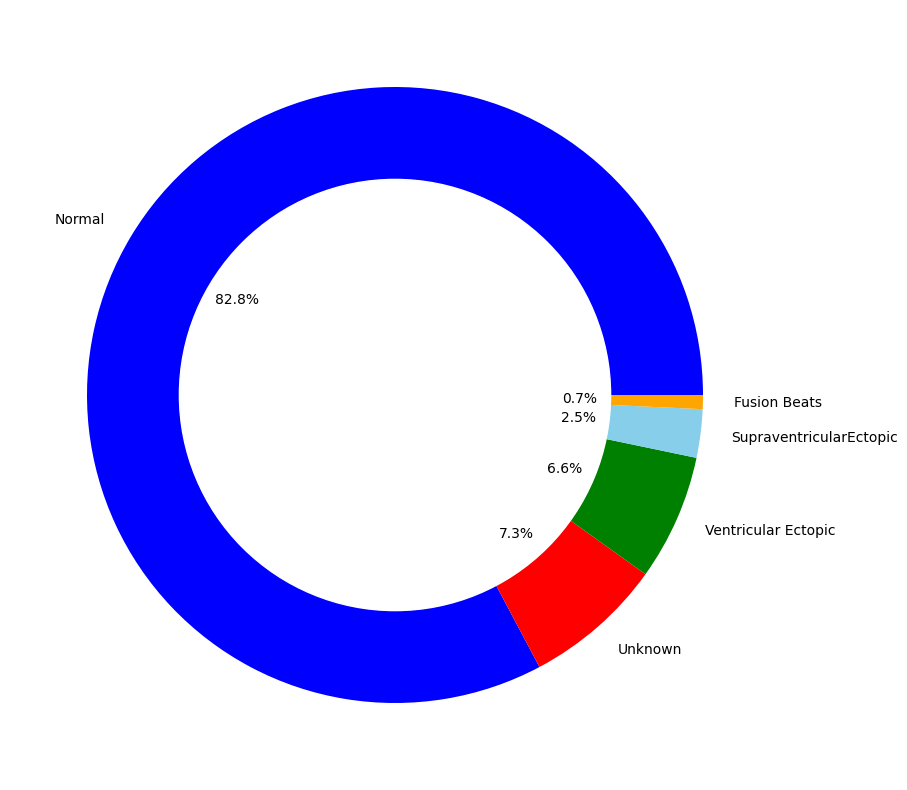

In [ ]:
#the classes stored in 187 index of test dataset with count
train[187]=train[187].astype(int)
train_classes=train[187].value_counts()
print()
#ploting a chart of the test database
plt.figure(figsize=(10,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(train_comb_classes, labels=['Normal','Unknown','Ventricular Ectopic','SupraventricularEctopic','Fusion Beats'], colors=['blue','red','green','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

0 - Normal ECG
1 - Supraventricular Ectopic ECG
2 - Ventricular Ectopic ECG
3 - Fusion Beats
4 - Unknown

In [ ]:
#Random Oversampling Imbalanced Datasets using resaple from slearn
from sklearn.utils import resample

#split the data set based on different classes
normal_over=(train[train[187]==0]).sample(n=645,random_state=52)
print("Normal ECG = ",(train[train[187]==0]).sample(n=645,random_state=52).shape)
#split class 1
a=train[train[187]==1]
print("Supraventricular Ectopic ECG = ",a.shape)
#random resample and add into dataset
a_over=resample(a,replace=True,n_samples=645,random_state=23)
print("Supraventricular Ectopic ECG = ",a_over.shape)

b=train[train[187]==2]
print("Ventricular Ectopic ECG = ",b.shape)
b_over=resample(b,replace=True,n_samples=645,random_state=24)
print("Ventricular Ectopic ECG = ",b_over.shape)

c=train[train[187]==3]
print("Fusion Beats = ",c.shape)
c_over=resample(c,replace=True,n_samples=645,random_state=25)
print("Fusion Beats = ",c_over.shape)

d=train[train[187]==4]
print("Unknown = ",d.shape)
d_over=resample(d,replace=True,n_samples=645,random_state=26)
print("Unknown = ",d_over.shape)


#combine the balanced resampled classes
train_ovr=pd.concat([normal_over,a_over,b_over,c_over,d_over])
#print(train_ovr.shape)




#combine the balanced resampled classes
#train_ovr=pd.concat([normal_over,a_over,b_over,d_over])
#print(train_ovr.shape)


Normal ECG =  (645, 188)
Supraventricular Ectopic ECG =  (2229, 188)
Supraventricular Ectopic ECG =  (645, 188)
Ventricular Ectopic ECG =  (5744, 188)
Ventricular Ectopic ECG =  (645, 188)
Fusion Beats =  (635, 188)
Fusion Beats =  (645, 188)
Unknown =  (6399, 188)
Unknown =  (645, 188)


In [ ]:

#split the data set based on different classes
normal_over=(test[test[187]==0]).sample(n=82,random_state=52)
print("Normal ECG = ",(test[test[187]==0]).sample(n=82,random_state=52).shape)
#split class 1
a=test[test[187]==1]
print("Supraventricular Ectopic ECG = ",a.shape)
#random resample and add into dataset
a_over=resample(a,replace=True,n_samples=82,random_state=23)
print("Supraventricular Ectopic ECG = ",a_over.shape)

b=test[test[187]==2]
print("Ventricular Ectopic ECG = ",b.shape)
b_over=resample(b,replace=True,n_samples=82,random_state=24)
print("Ventricular Ectopic ECG = ",b_over.shape)

c=test[test[187]==3]
print("Fusion Beats = ",c.shape)
c_over=resample(c,replace=True,n_samples=82,random_state=25)
print("Fusion Beats = ",c_over.shape)

d=test[test[187]==4]
print("Unknown = ",d.shape)
d_over=resample(d,replace=True,n_samples=82,random_state=26)
print("Unknown = ",d_over.shape)


#combine the balanced resampled classes
test_ovr=pd.concat([normal_over,a_over,b_over,c_over,d_over])
#print(test_ovr.shape)

#combine the balanced resampled classes
#test_ovr=pd.concat([normal_over,a_over,b_over,d_over])
#print(test_ovr.shape)


Normal ECG =  (82, 188)
Supraventricular Ectopic ECG =  (265, 188)
Supraventricular Ectopic ECG =  (82, 188)
Ventricular Ectopic ECG =  (750, 188)
Ventricular Ectopic ECG =  (82, 188)
Fusion Beats =  (83, 188)
Fusion Beats =  (82, 188)
Unknown =  (830, 188)
Unknown =  (82, 188)


In [ ]:
#Random Oversampling Imbalanced Datasets using resaple from slearn
from sklearn.utils import resample

#split the data set based on different classes
normal_over=(validate[validate[187]==0]).sample(n=71,random_state=52)
print("Normal ECG = ",(validate[validate[187]==0]).sample(n=71,random_state=52).shape)
#split class 1
a=validate[validate[187]==1]
print("Supraventricular Ectopic ECG = ",a.shape)
#random resample and add into dataset
a_over=resample(a,replace=True,n_samples=71,random_state=23)
print("Supraventricular Ectopic ECG = ",a_over.shape)

b=validate[validate[187]==2]
print("Ventricular Ectopic ECG = ",b.shape)
b_over=resample(b,replace=True,n_samples=71,random_state=24)
print("Ventricular Ectopic ECG = ",b_over.shape)

c=validate[validate[187]==3]
print("Fusion Beats = ",c.shape)
c_over=resample(c,replace=True,n_samples=71,random_state=25)
print("Fusion Beats = ",c_over.shape)

d=validate[validate[187]==4]
print("Unknown = ",d.shape)
d_over=resample(d,replace=True,n_samples=71,random_state=26)
print("Unknown = ",d_over.shape)


#combine the balanced resampled classes
validate_ovr=pd.concat([normal_over,a_over,b_over,c_over,d_over])
#print(validate_ovr.shape)

validate_ovr = pd.concat([validate_ovr , test_ovr])


#combine the balanced resampled classes
#validate_ovr=pd.concat([normal_over,a_over,b_over,d_over])
#print(validate_ovr.shape)


Normal ECG =  (71, 188)
Supraventricular Ectopic ECG =  (285, 188)
Supraventricular Ectopic ECG =  (71, 188)
Ventricular Ectopic ECG =  (742, 188)
Ventricular Ectopic ECG =  (71, 188)
Fusion Beats =  (85, 188)
Fusion Beats =  (71, 188)
Unknown =  (810, 188)
Unknown =  (71, 188)


In [ ]:
#classes are balanced
Oversampled_classes=train_ovr[187].value_counts()
print(Oversampled_classes)

0    645
1    645
2    645
3    645
4    645
Name: 187, dtype: int64


In [ ]:
class_train=train_ovr[187]
y_train=to_categorical(class_train)
X_train=train_ovr.iloc[:,:186].values


class_val=validate_ovr[187]
y_val=to_categorical(class_val)
X_val=validate_ovr.iloc[:,:186].values


class_test=test_ovr[187]
y_test_mat = test_ovr[187] 
y_test=to_categorical(class_test)
print(y_test)
X_test=test_ovr.iloc[:,:186].values


[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


Little bit Data Transformation

In [ ]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
print(X_train.shape)

y_train = scaler.fit_transform(y_train)
print(y_train.shape)
y_train_LSTM = y_train.copy()
y_train = np.reshape(y_train, (y_train.shape[0],1,y_train.shape[1]))
print(y_train.shape)

X_val = scaler.fit_transform(X_val)
print(X_val.shape)
X_val = np.reshape(X_val, (X_val.shape[0],1,X_val.shape[1]))
print(X_val.shape)

y_val = scaler.fit_transform(y_val)
print(y_val.shape)
y_val_LSTM = y_val.copy()
y_val = np.reshape(y_val, (y_val.shape[0],1,y_val.shape[1]))
print(y_val.shape)

X_test = scaler.fit_transform(X_test)
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
print(X_test.shape)

y_test = scaler.fit_transform(y_test)
print(y_test.shape)
y_test_LSTM = y_test.copy()
y_test = np.reshape(y_test, (y_test.shape[0],1,y_test.shape[1]))
print(y_test.shape)


#x_test = scaler.fit_transform(x_test)
#x_test = np.reshape(x_test, (x_test.shape[0],1,X.shape[1]))

(3225, 186)
(3225, 1, 186)
(3225, 5)
(3225, 1, 5)
(765, 186)
(765, 1, 186)
(765, 5)
(765, 1, 5)
(410, 186)
(410, 1, 186)
(410, 5)
(410, 1, 5)


In [ ]:
from keras.models import Sequential

model = Sequential()

from keras.layers import Dense

model.add(Dense(164, activation='relu', input_shape=(1,186)))
model.add(Dense(32,activation="sigmoid"))
model.add(Dense(32, activation='softmax'))
model.add(Dense(5, activation="softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 164)            30668     
                                                                 
 dense_1 (Dense)             (None, 1, 32)             5280      
                                                                 
 dense_2 (Dense)             (None, 1, 2)              66        
                                                                 
 dense_3 (Dense)             (None, 1, 5)              15        
                                                                 
Total params: 36,029
Trainable params: 36,029
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(X_train, y_train,epochs=50,validation_data=(X_val,y_val))
#model.load_weights('best_model.h5')

Epoch 1/50
101/101 [==============================] - 2s 6ms/step - loss: -0.3217 - accuracy: 0.2633 - val_loss: -0.5212 - val_accuracy: 0.3268
Epoch 2/50
101/101 [==============================] - 0s 3ms/step - loss: -0.6388 - accuracy: 0.3250 - val_loss: -0.7074 - val_accuracy: 0.4157
Epoch 3/50
101/101 [==============================] - 0s 3ms/step - loss: -0.8350 - accuracy: 0.4127 - val_loss: -0.8871 - val_accuracy: 0.4052
Epoch 4/50
101/101 [==============================] - 0s 4ms/step - loss: -1.0180 - accuracy: 0.4040 - val_loss: -1.0536 - val_accuracy: 0.3948
Epoch 5/50
101/101 [==============================] - 0s 3ms/step - loss: -1.1729 - accuracy: 0.3941 - val_loss: -1.2003 - val_accuracy: 0.4013
Epoch 6/50
101/101 [==============================] - 0s 3ms/step - loss: -1.3316 - accuracy: 0.3963 - val_loss: -1.3495 - val_accuracy: 0.3987
Epoch 7/50
101/101 [==============================] - 0s 3ms/step - loss: -1.4678 - accuracy: 0.3960 - val_loss: -1.4404 - val_accuracy:

24/24 [==============================] - 0s 2ms/step - loss: -6.1383 - accuracy: 0.4052
Accuracy: 40.52%


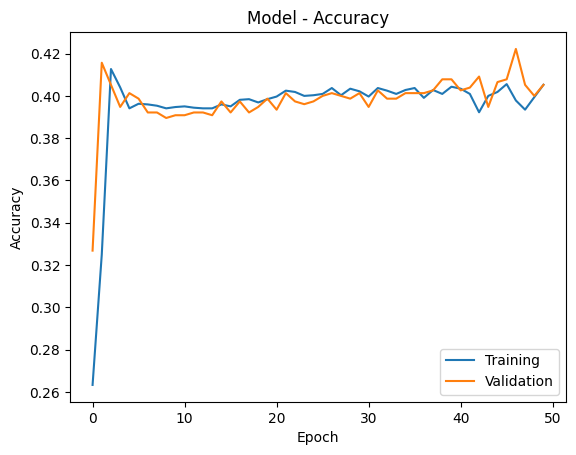

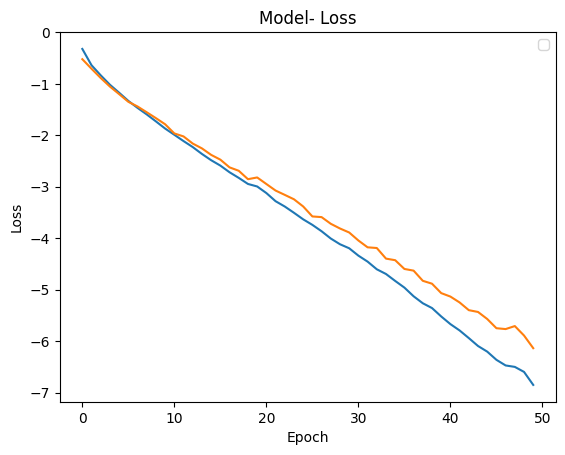

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

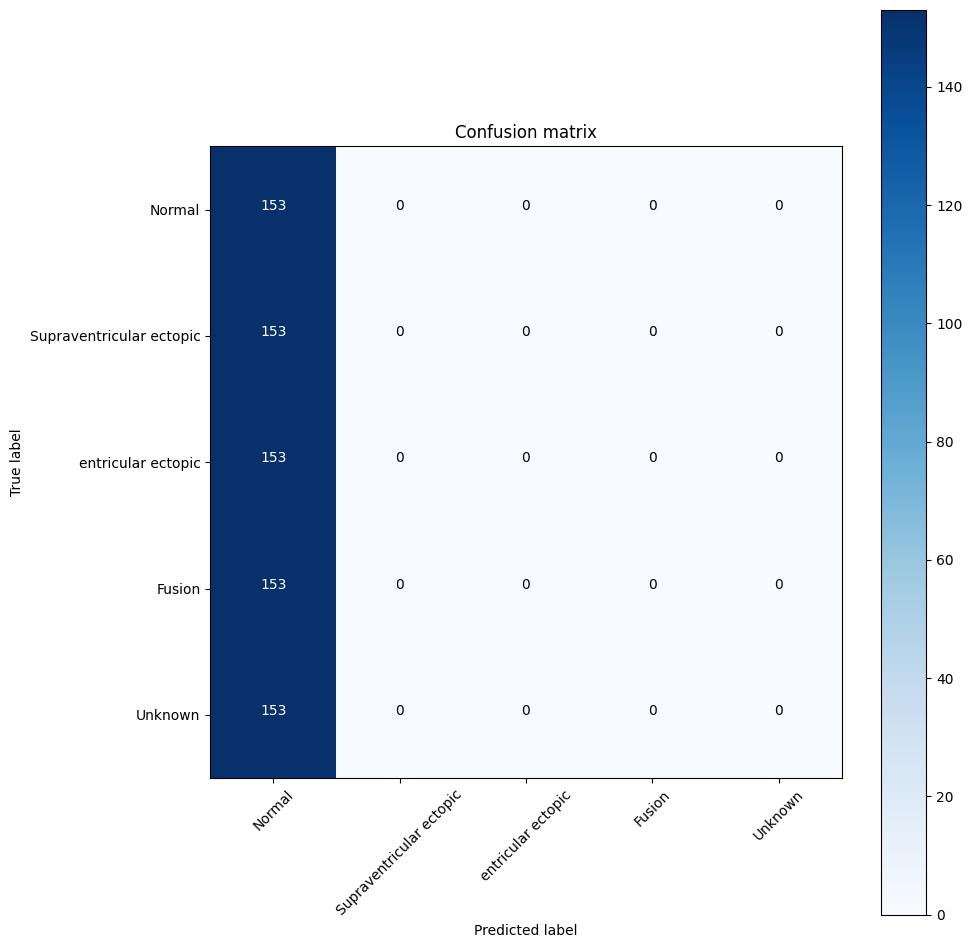

[[153   0   0   0   0]
 [153   0   0   0   0]
 [153   0   0   0   0]
 [153   0   0   0   0]
 [153   0   0   0   0]]
<class 'numpy.ndarray'>
24/24 [==============================] - 0s 2ms/step


In [ ]:
cons_mat = evaluate_model( history ,X_val,y_val, model )
print(cons_mat)
print(type(cons_mat))
y_pred=model.predict( X_val )


In [ ]:

l1 = ['Normal', 'Supraventricular ectopic', 'entricular ectopic', 'Fusion', 'Unknown']
print_matrix(ListMaker( 5 , cons_mat) , l1)

Normal  Sensitivity =  1.0
Normal  Specificity =  0.0
Normal  Positive Predictive Value =  0.2
Normal  Diagonstic Odds Ratio =  inf
Normal  Cohen Kappa =  1.0000068350363966






Supraventricular ectopic  Sensitivity =  0.0
Supraventricular ectopic  Specificity =  1.0
Supraventricular ectopic  Positive Predictive Value =  inf
Supraventricular ectopic  Diagonstic Odds Ratio =  inf
Supraventricular ectopic  Cohen Kappa =  1.0000004271870375






entricular ectopic  Sensitivity =  0.0
entricular ectopic  Specificity =  1.0
entricular ectopic  Positive Predictive Value =  inf
entricular ectopic  Diagonstic Odds Ratio =  inf
entricular ectopic  Cohen Kappa =  1.0000004271870375






Fusion  Sensitivity =  0.0
Fusion  Specificity =  1.0
Fusion  Positive Predictive Value =  inf
Fusion  Diagonstic Odds Ratio =  inf
Fusion  Cohen Kappa =  1.0000004271870375






Unknown  Sensitivity =  0.0
Unknown  Specificity =  1.0
Unknown  Positive Predictive Value =  inf
Unknown  Diagonstic Odds Ratio =

LSTM

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(1,186),activation="relu",return_sequences=True))
model.add(LSTM(32,activation="sigmoid"))
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
model.summary()
Y_train = to_categorical(class_train)
history = model.fit(X_train, y_train_LSTM, epochs = 30, validation_data=(X_val,y_val_LSTM))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             64256     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 76,837
Trainable params: 76,837
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
101/101 [==============================] - 4s 10ms/step - loss: -1.3785 - accuracy: 0.4974 - val_loss: -2.6652 - val_accuracy: 0.6614
Epoch 2/30
101/101 [==============================] - 0s 5ms/step - loss: -3.5575 - accuracy: 0.7225 - val_loss: -4.1573 - val_accuracy: 0.7359
Epoch 3/30
101/101 [=======

24/24 [==============================] - 0s 2ms/step - loss: -25.5978 - accuracy: 0.8784
Accuracy: 87.84%


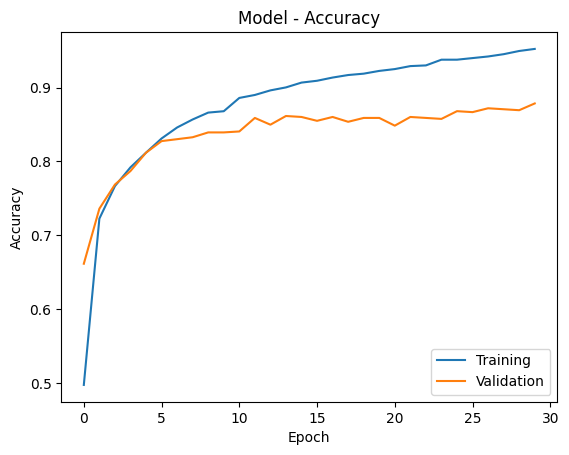

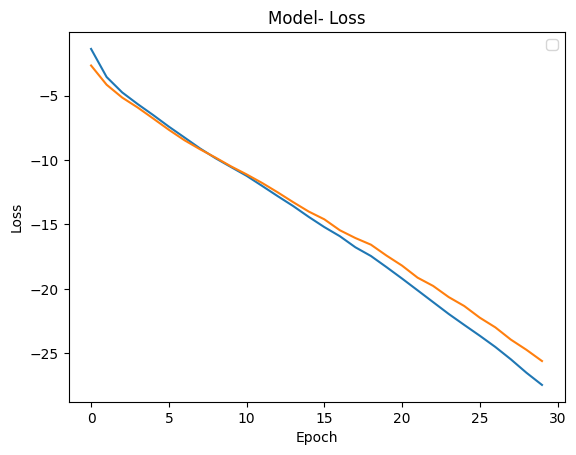

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

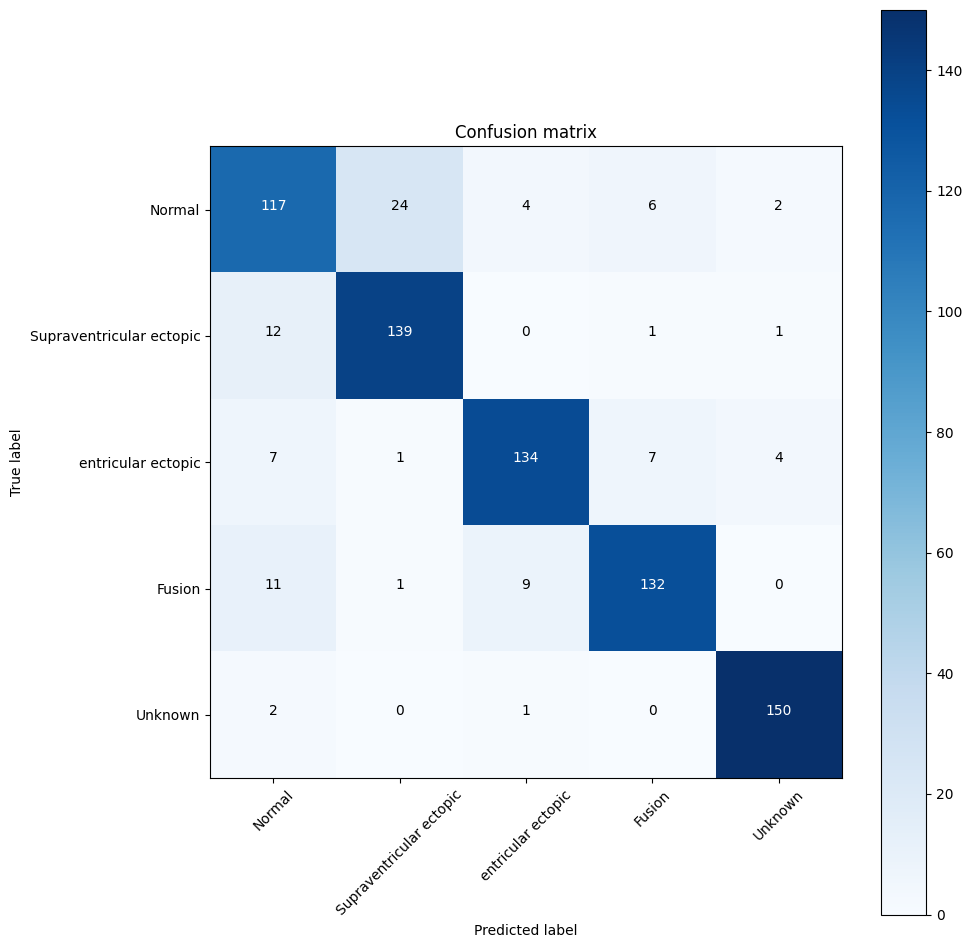

24/24 [==============================] - 0s 2ms/step


In [ ]:


cons_mat = evaluate_model( history ,X_val,y_val_LSTM, model )
y_pred=model.predict( X_val )




In [ ]:

l1 = ['Normal', 'Supraventricular ectopic', 'entricular ectopic', 'Fusion', 'Unknown']
print_matrix(ListMaker( 5 , cons_mat) , l1)


Normal  Sensitivity =  0.7647058823529411
Normal  Specificity =  0.9477124183006536
Normal  Positive Predictive Value =  0.785234899328859
Normal  Diagonstic Odds Ratio =  58.90625
Normal  Cohen Kappa =  1.0000002223400624






Supraventricular ectopic  Sensitivity =  0.9084967320261438
Supraventricular ectopic  Specificity =  0.9575163398692811
Supraventricular ectopic  Positive Predictive Value =  0.8424242424242424
Supraventricular ectopic  Diagonstic Odds Ratio =  223.77472527472528
Supraventricular ectopic  Cohen Kappa =  1.0000001332357782






entricular ectopic  Sensitivity =  0.8758169934640523
entricular ectopic  Specificity =  0.9771241830065359
entricular ectopic  Positive Predictive Value =  0.9054054054054054
entricular ectopic  Diagonstic Odds Ratio =  301.2481203007519
entricular ectopic  Cohen Kappa =  1.0000001077765852






Fusion  Sensitivity =  0.8627450980392157
Fusion  Specificity =  0.9771241830065359
Fusion  Positive Predictive Value =  0.9041095890410958
Fu